In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [78]:
cd /content/gdrive/My Drive/TARP

/content/gdrive/My Drive/TARP


In [ ]:
!pip install roboflow

In [79]:
from roboflow import Roboflow
rf = Roboflow(api_key="Xgj9V3xRziKFbRdCAhR9")
project = rf.workspace("idciti").project("droneandbird")
dataset = project.version(2).download("retinanet")

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to droneandbird-2 in retinanet:: 100%|██████████| 2366/2366 [00:14<00:00, 164.59it/s]


In [5]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6224, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6224 (delta 6), reused 6 (delta 2), pack-reused 6205
Receiving objects: 100% (6224/6224), 13.48 MiB | 13.87 MiB/s, done.
Resolving deltas: 100% (4207/4207), done.


In [6]:
!pip install keras==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
%cd keras-retinanet/

!pip install .

/content/gdrive/My Drive/TARP/keras-retinanet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gdrive/My Drive/TARP/keras-retinanet
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp39-cp39-linux_x86_64.whl size=180856 sha256=035c8d258f73c3cb7e37a7f18a00d3914b6037f499be5a73f6ac6127dd80cbf9
  Stored in directory: /root/.cache/pip/wheels/c2/8a/fe/2a3e4147a1ec2d67a05e8dc6dc0d672bde3e29c1afa5362a2e
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20484 sha256=d80f9e2b4bacd44efa176a6c9e9389646873d9c7b34b00a65f10f3d634cde9c1
  Stored in directory: /root/.cache/pip/wheels/53/ed/ef/144804f160c278c80d6429c97ed126b61276721894ce64cccc
Successfully built keras-retinanet keras-resnet


In [8]:
!python setup.py build_ext --inplace

/usr/local/lib/python3.9/dist-packages/setuptools/__init__.py:85: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated. Requirements should be satisfied by a PEP 517 installer. If you are using pip, you can try `pip install --use-pep517`.
  dist.fetch_build_eggs(dist.setup_requires)
running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.9/keras_retinanet/utils/compute_overlap.cpython-39-x86_64-linux-gnu.so -> keras_retinanet/utils


In [9]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [11]:
os.makedirs("snapshots", exist_ok=True)

In [86]:
an = "/content/gdrive/My Drive/TARP/droneandbird-2/train/_annotations.csv"

anot = pd.read_csv(an,header=None)

anot.columns = ["image_name","x_min","y_min","x_max","y_max","output"]
anot.head()

an = "/content/gdrive/My Drive/TARP/droneandbird-2/train/"

jp=0

for k in range(anot.shape[0]):
  anot.iloc[k,0] = an+anot.iloc[k,0]

In [87]:
anot.head()

image_name  x_min  y_min  x_max  \
0  /content/gdrive/My Drive/TARP/droneandbird-2/t...    255    197    393   
1  /content/gdrive/My Drive/TARP/droneandbird-2/t...    377    197    411   
2  /content/gdrive/My Drive/TARP/droneandbird-2/t...    350    284    389   
3  /content/gdrive/My Drive/TARP/droneandbird-2/t...    265    199    299   
4  /content/gdrive/My Drive/TARP/droneandbird-2/t...    370    282    442   

   y_max output  
0    364  drone  
1    251  drone  
2    322  drone  
3    232  drone  
4    346  drone

In [88]:
print(anot.shape)

(2426, 6)


In [89]:
classes = dict()
classes["class_name"] = ["drone","bird"]
classes["id"] = [0,1]

cl = pd.DataFrame(classes)

cl.head()

class_name  id
0      drone   0
1       bird   1

In [83]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

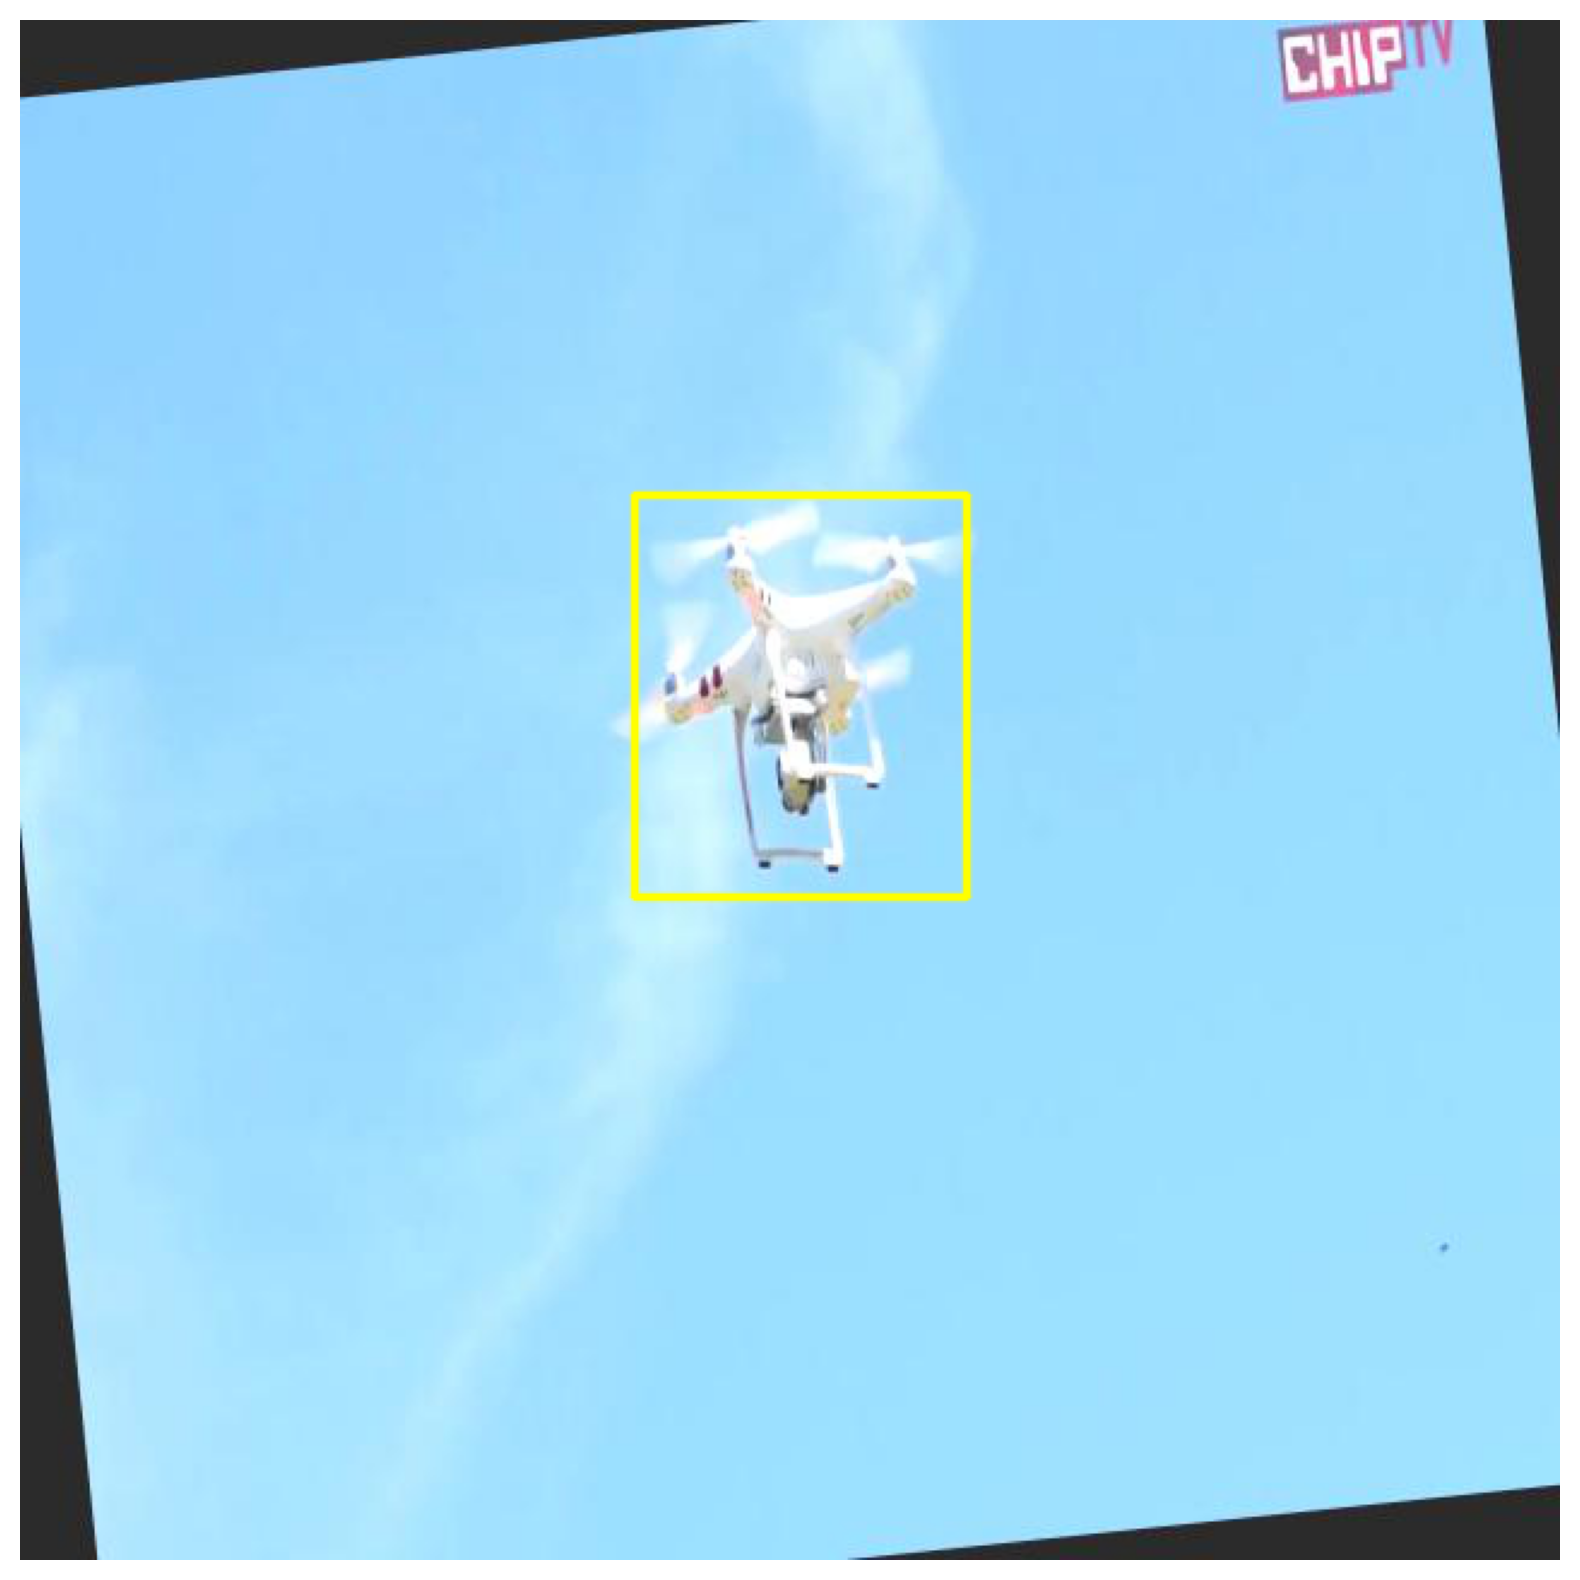

In [84]:
show_image_objects(anot.iloc[0])

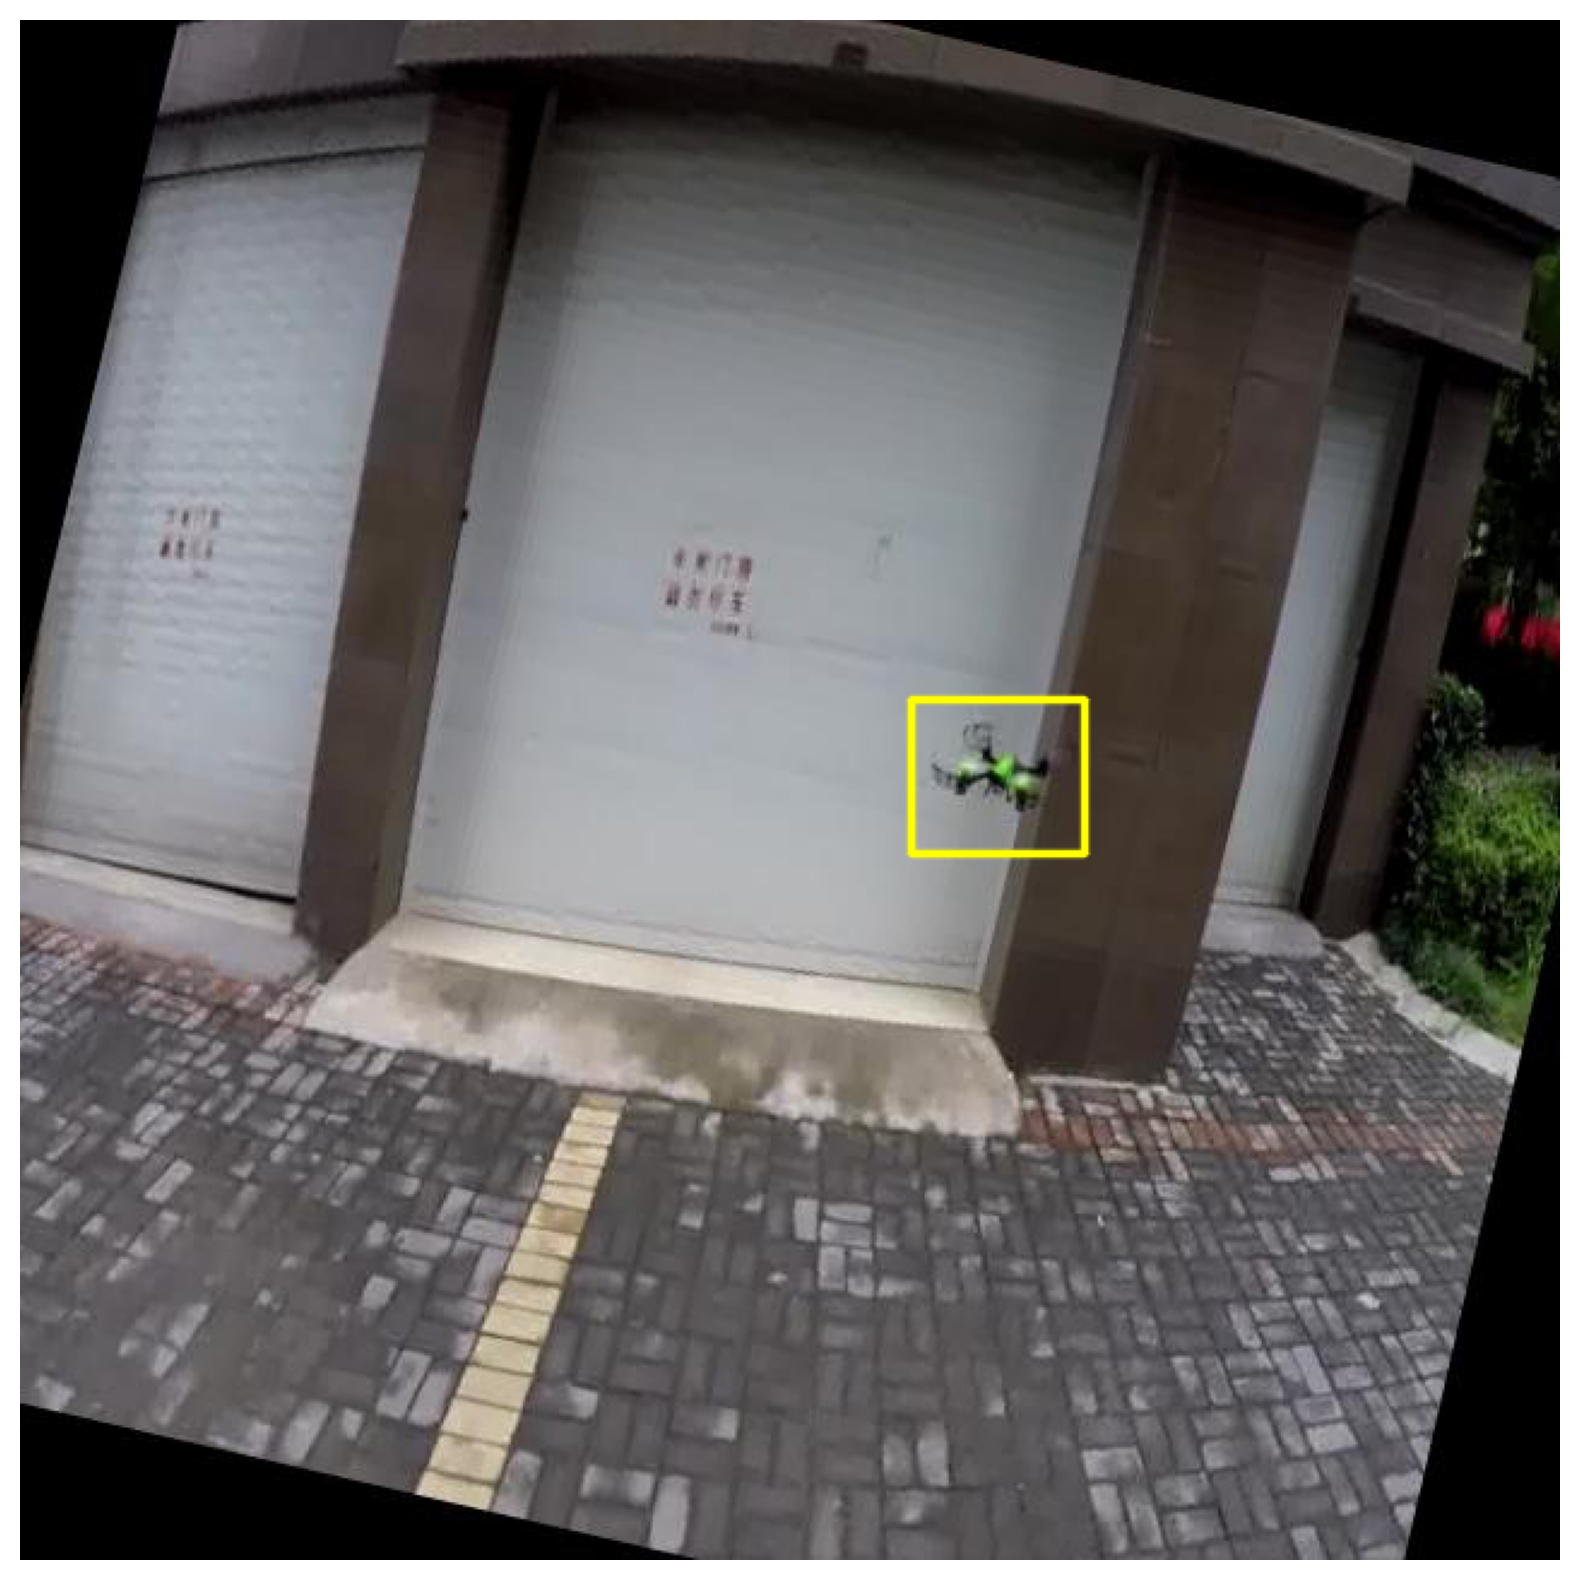

In [85]:
show_image_objects(anot.iloc[4])

# Preprocessing

In [90]:
train_df, test_df = train_test_split(
  anot, 
  test_size=0.1, 
  random_state=RANDOM_SEED
)

In [91]:
print(len(train_df))

2183


In [97]:
cd /content/gdrive/My Drive/TARP/keras-retinanet

/content/gdrive/My Drive/TARP/keras-retinanet


In [98]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [99]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)
cl.to_csv(CLASSES_FILE, index=False, header=None)

In [100]:
!head classes.csv

drone,0
bird,1


In [101]:
!head annotations.csv

/content/gdrive/My Drive/TARP/droneandbird-2/train/video18_1107_JPEG.rf.18483fca53f95d6a0c873c7acb10145d.jpg,289,423,348,499,drone
/content/gdrive/My Drive/TARP/droneandbird-2/train/video17_978_JPEG.rf.5d95f924b396135f55d9263c8dc4e9a1.jpg,297,205,400,280,drone
/content/gdrive/My Drive/TARP/droneandbird-2/train/127_JPEG.rf.6b3d3a60a837f05640d6848a5177f0e8.jpg,219,272,238,291,drone
/content/gdrive/My Drive/TARP/droneandbird-2/train/video18_1332_JPEG.rf.0c844b050191369e6359e174d2f2970b.jpg,154,193,182,227,drone
/content/gdrive/My Drive/TARP/droneandbird-2/train/video17_741_JPEG.rf.d6ba0cf1e081f388c8a58de7fcfb6cc5.jpg,354,271,426,325,drone
/content/gdrive/My Drive/TARP/droneandbird-2/train/210_JPEG.rf.10c60440e3465deba47b5ce0adfc9b88.jpg,167,337,245,414,drone
/content/gdrive/My Drive/TARP/droneandbird-2/train/video17_1030_JPEG.rf.9858673d1618453658515fc9246481fd.jpg,283,6,463,242,drone
/content/gdrive/My Drive/TARP/droneandbird-2/train/159_JPEG.rf.f28d96631dd51c8087216560e58275b4.jpg,292,3

# Training

In [102]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [103]:
!chmod 755 keras_retinanet/bin/train.py

In [104]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 5 csv annotations.csv classes.csv

2023-04-18 09:41:23.512185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating model, this may take a second...
2023-04-18 09:41:31.087105: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1

# Loading the trained model

In [105]:
cd /content/gdrive/My Drive/TARP/keras-retinanet

/content/gdrive/My Drive/TARP/keras-retinanet


In [106]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_01.h5


In [107]:
CLASSES_FILE = 'classes.csv'

model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_01.h5


The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.


In [108]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [109]:
from PIL import Image

def show_detected_objects(image_row,dr):
  if dr==1: 
    img_path = image_row.image_name
  
    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    true_box = [
      image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
    ]
    draw_box(draw, true_box, color=(255, 255, 0))

    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.show()
  
  else:  
    image = read_image_bgr(image_row)

    boxes, scores, labels = predict(image)

    for i in range(len(boxes[0])):
      # Crop the image
      print(boxes[0][i])
      img = Image.open(image_row)

      roi = img.crop((int(boxes[0][i][0]),int(boxes[0][i][1]),int(boxes[0][i][2]),int(boxes[0][i][3])))

      # Save the cropped image
      y = "../final_output/"+classes['class_name'][labels[0][i]]
      name_length = len(os.listdir(y))+1
      z = "../final_output/"+classes['class_name'][labels[0][i]]+"/"+str(name_length)+".jpg"
      print(z)
      print(y)
      roi.save(z)

In [110]:
THRES_SCORE = 0.6

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

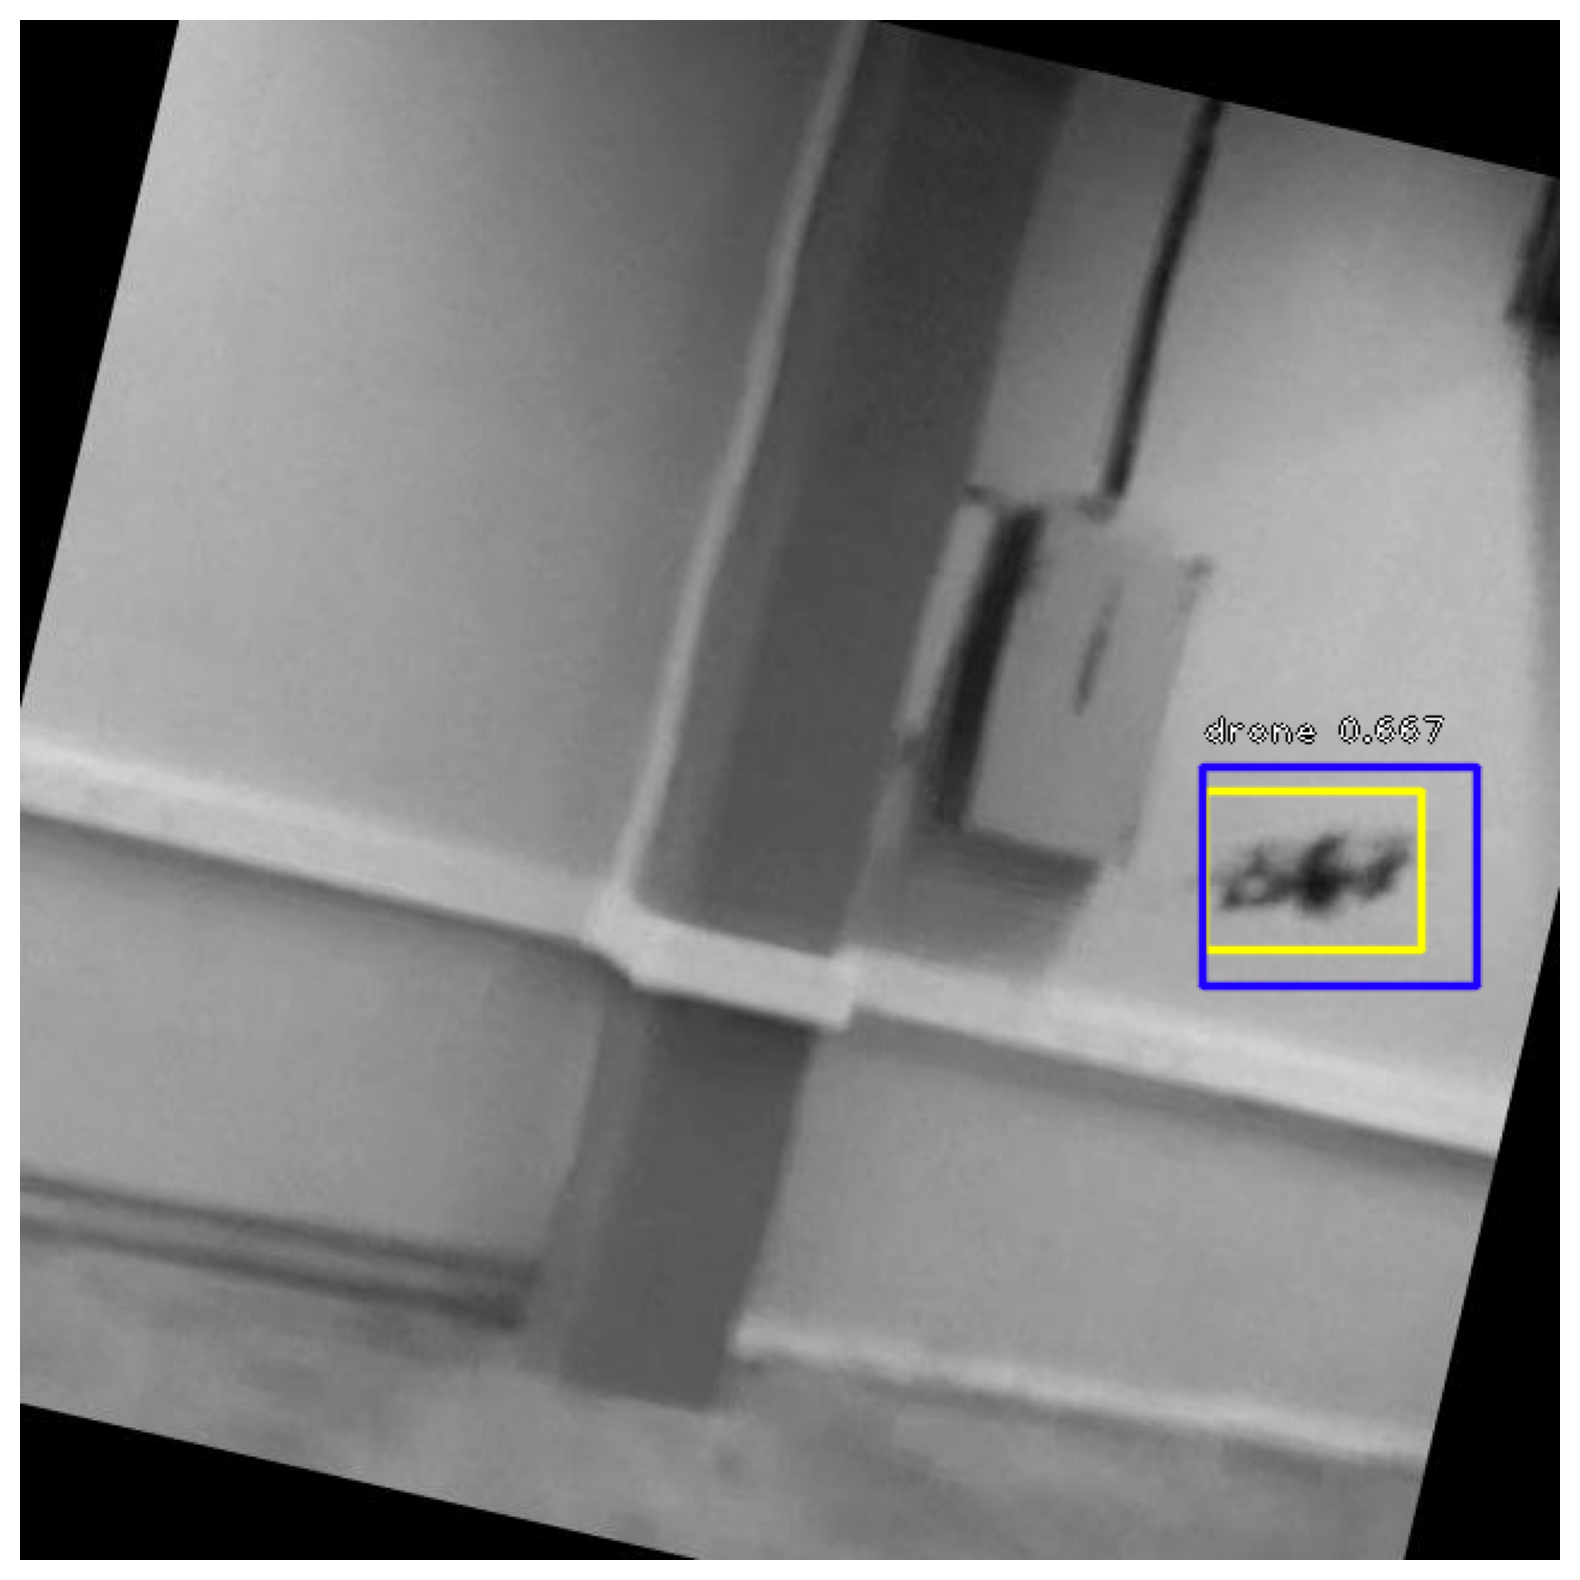

In [111]:
show_detected_objects(test_df.iloc[0],1)

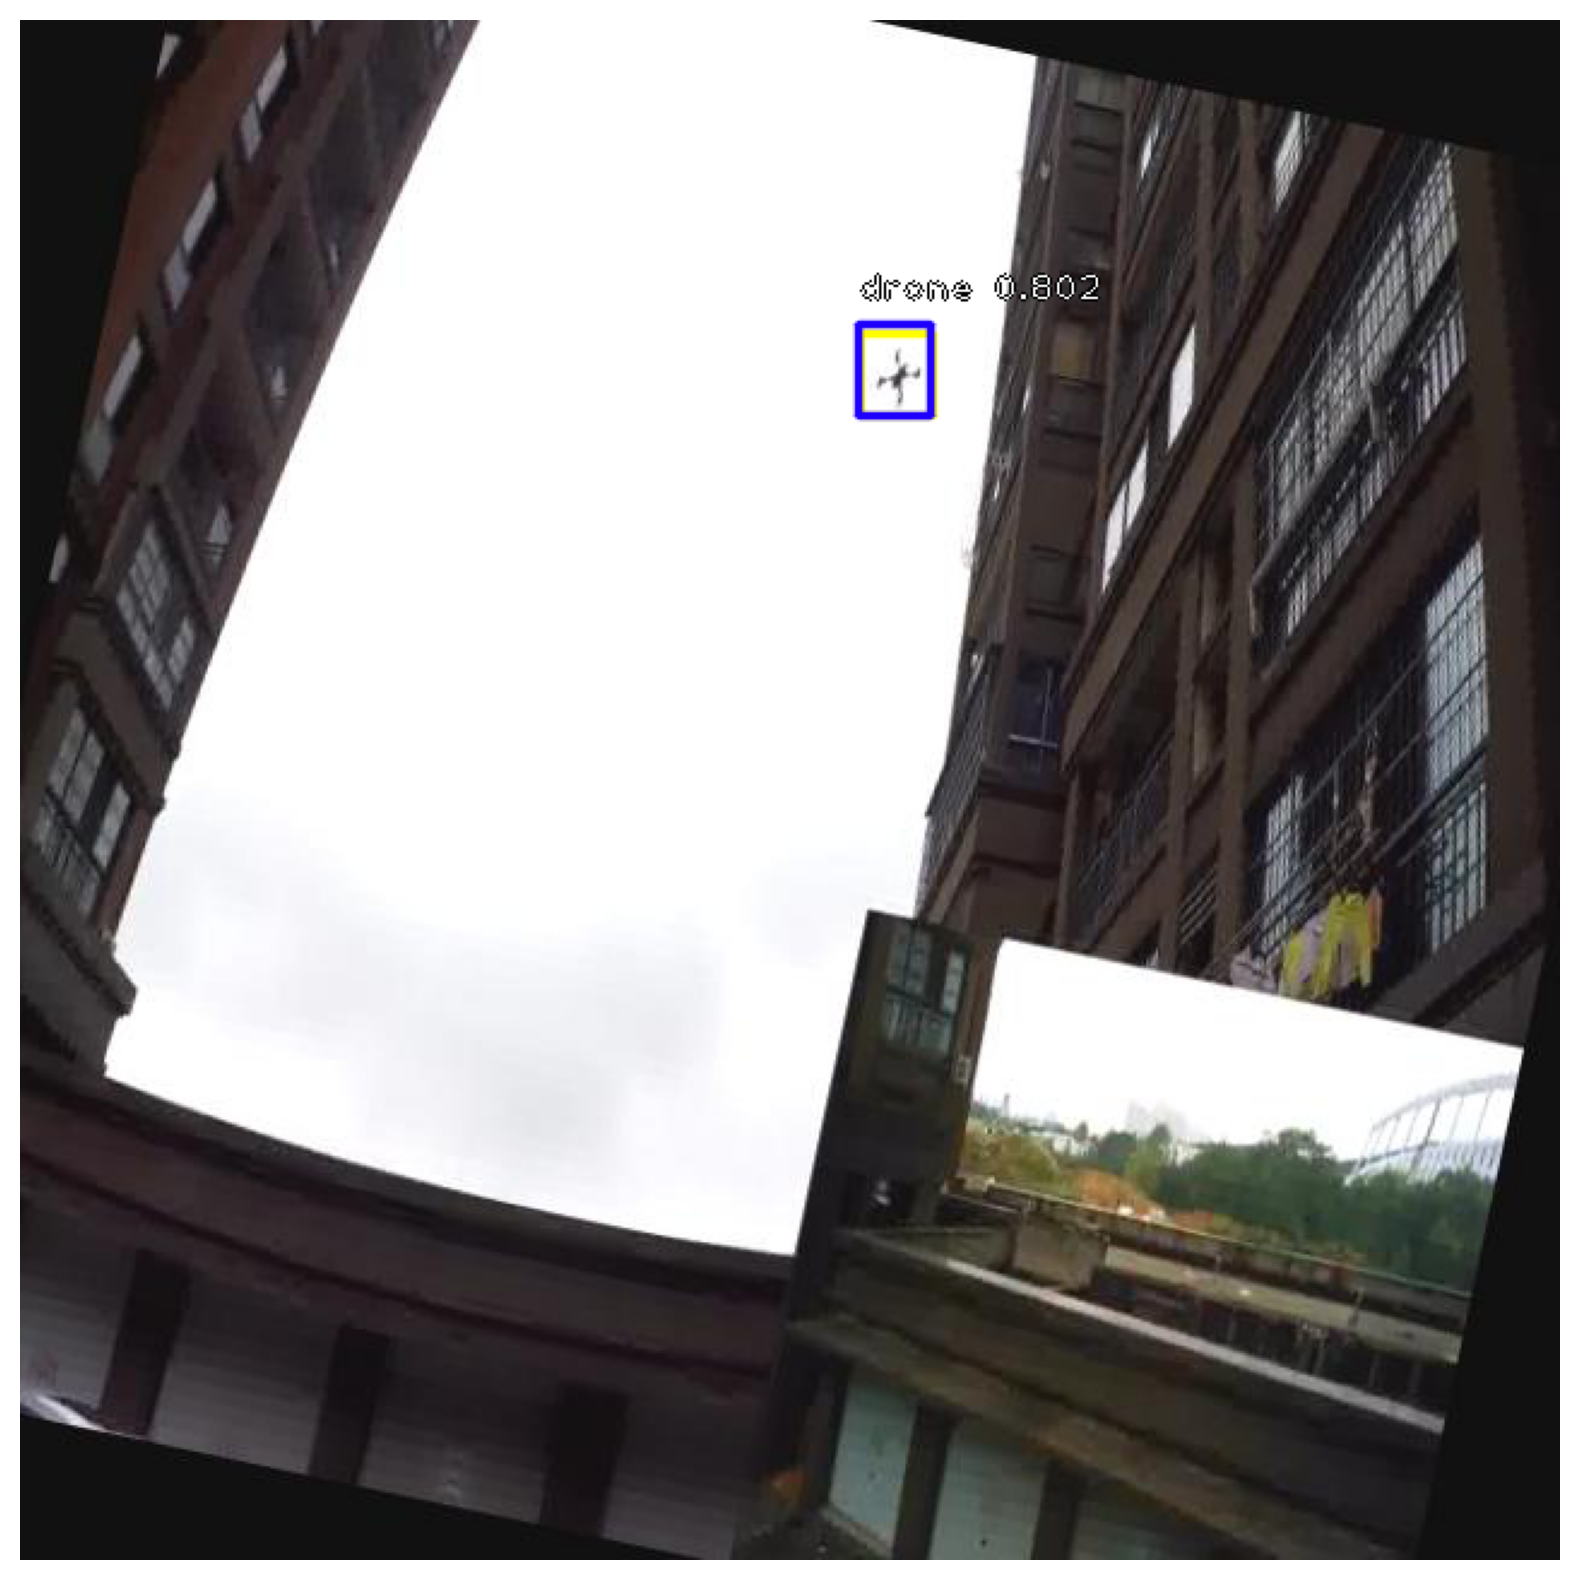

In [112]:
show_detected_objects(test_df.iloc[10],1)